# Imports, load the image

In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"
import cv2
from PIL import Image, ImageOps

from calibration.features.checkerboard import (
    checkerboard_score,
    create_correlation_patch,
    detect_checkerboard,
    detect_corners,
    detect_corners_template,
    get_angle_modes,
    get_corner_candidates,
    make_mask_line,
    non_maximum_suppression,
    normalize_image,
    refine_corners,
    reorder_checkerboard,
    score_corners,
    solve_patch_corner,
    trim_picture,
)

In [3]:
def show(img: np.array):
    return px.imshow(img, binary_string=len(img.shape) == 2 or img.shape[2] == 1)

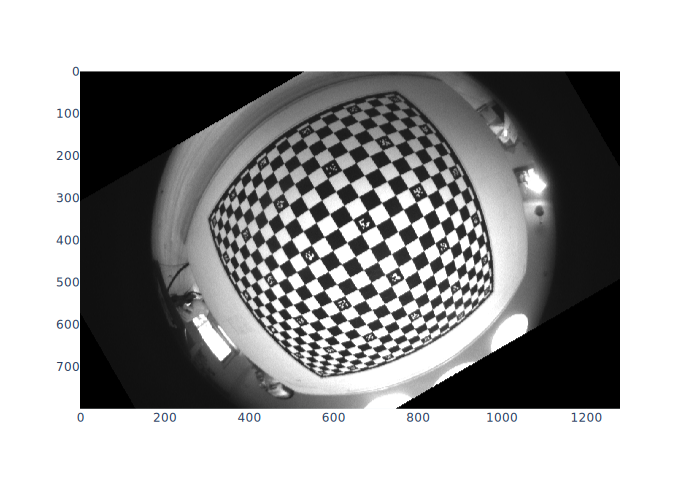

In [4]:
charuco_img_path = "../data/BabelCalib/Kalibr/Kalibr/BF2M2020S23/train/img0001.pgm"
checkerboard_img_path = (
    "../data/BabelCalib/OCamCalib/OCamCalib/Fisheye1/train/Fisheye1_10.jpg"
)
checkerboard_img_path_distorted = "../data/BabelCalib/OV/OV/single_plane/130108MP/train/br0_cam01-2020-05-07-13-09-12.png"

img = Image.open(charuco_img_path)
img = Image.open(checkerboard_img_path)
img = Image.open(checkerboard_img_path_distorted)

img = img.rotate(30)
gray = np.array(ImageOps.grayscale(img))
show(gray)

# Trim

This part kind of crops the largest connected component or something, but it works poorly.

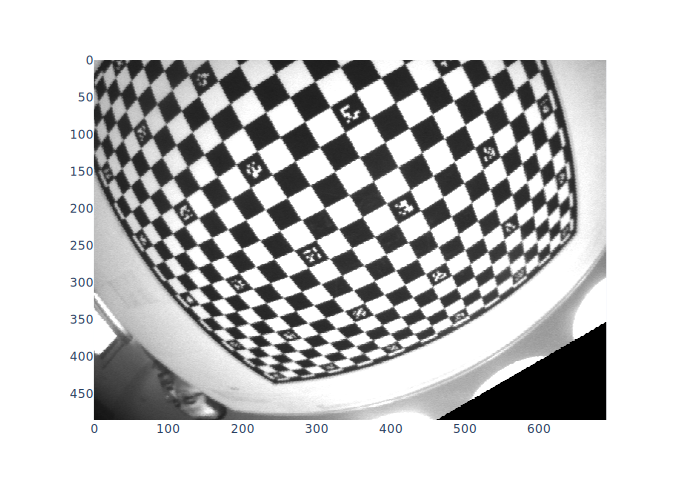

In [5]:
if True:
    gray_cropped, crop_start = trim_picture(gray)
else:
    crop_start = [0, 0]

show(gray_cropped)

# Normalize

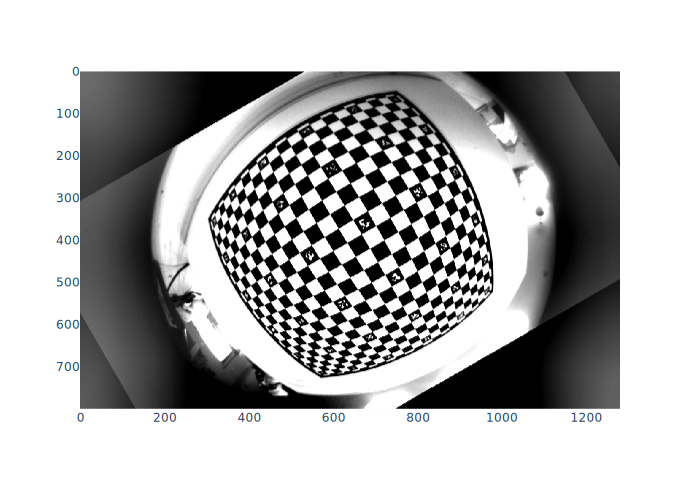

In [6]:
diff = normalize_image(gray)
show(diff)

# Detect corners

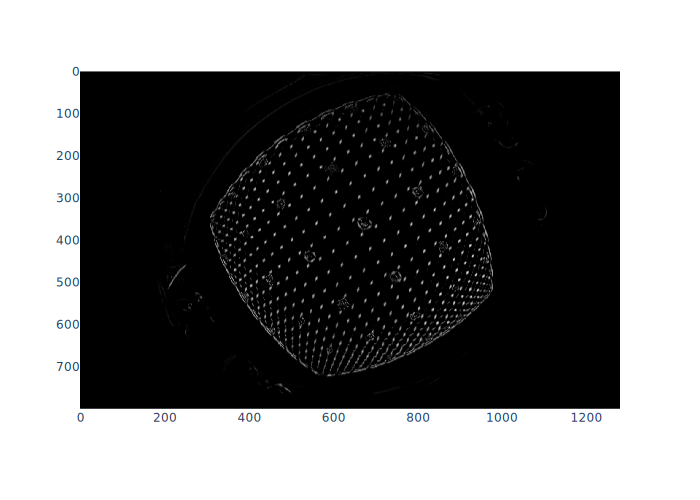

In [7]:
winsize = 9
radiuses = [winsize + 3]
if winsize >= 8:
    radiuses.append(winsize - 3)

corr = detect_corners(diff, radiuses=radiuses)
show(corr)

# Get corner coordinates

Argmax in region

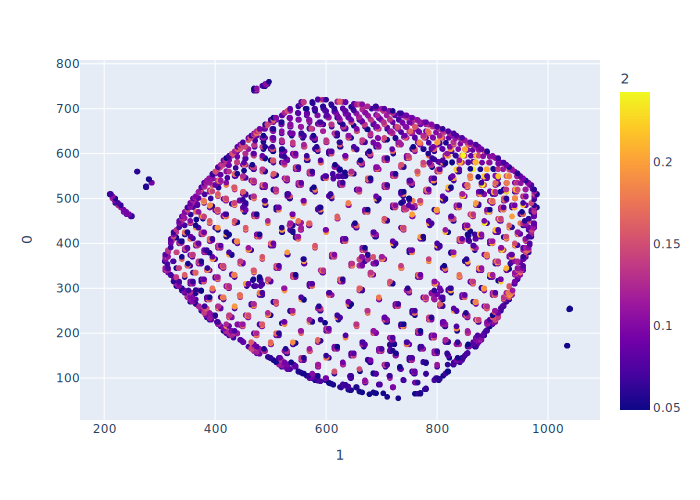

In [8]:
corrb = cv2.GaussianBlur(corr, (7, 7), 3)
corners = get_corner_candidates(corrb, winsize + 2, np.max(corrb) * 0.2)
px.scatter(corners, y=0, x=1, color=2)

# Non-maximum supression

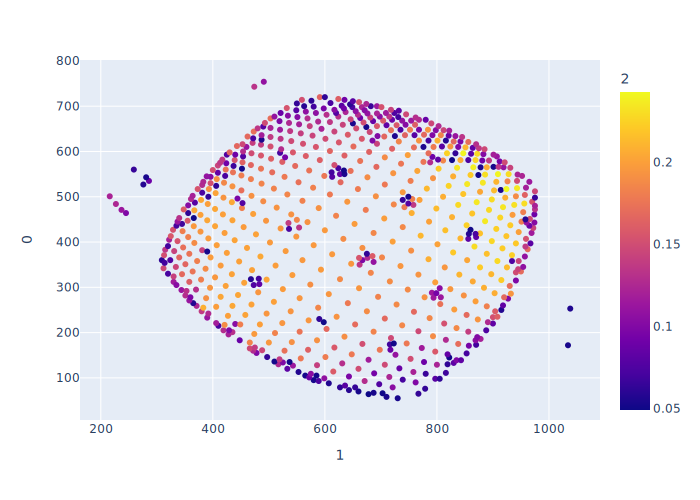

In [9]:
corners = non_maximum_suppression(corners, winsize - 2)
px.scatter(corners, y=0, x=1, color=2)

# Refine corners

I'm not yet sure how it works

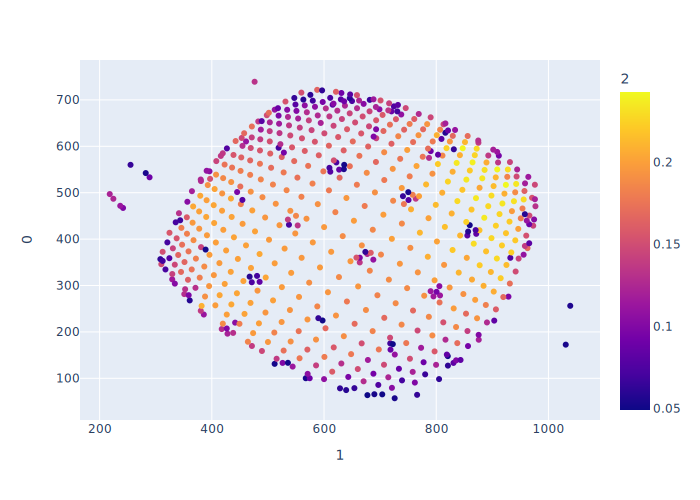

In [10]:
corners_sp = refine_corners(corners, diff, winsize=winsize + 2)
px.scatter(corners_sp, y=0, x=1, color=2)

# Leave only the best corners (as many as we need according to the board size)

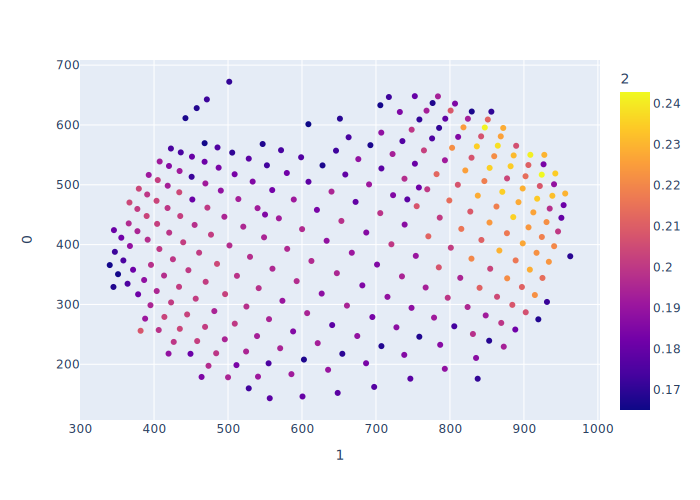

In [11]:
scores = corners_sp[:, 2]

# size = (7, 9)
size = (17, 17)
num_corners = size[0] * size[1]

best_ix = np.argsort(-scores)[: num_corners + 3]
best_corners = corners_sp[np.sort(best_ix)]
px.scatter(best_corners, y=0, x=1, color=2)

# Reorder checkerboard

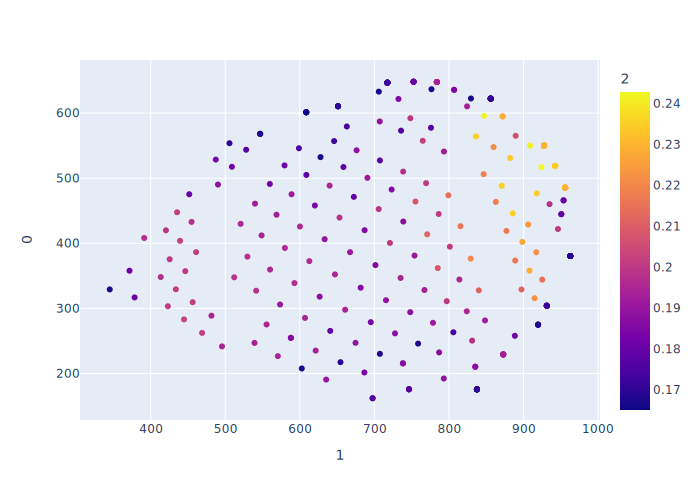

In [12]:
best_corners, max_dist = reorder_checkerboard(best_corners, diff, size)
px.scatter(best_corners, y=0, x=1, color=2)